refer to https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import numpy as np
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('update_20190301_bitbank_f.csv', header=0, index_col=0)
values = dataset.values

dataset.head()

Using TensorFlow backend.


,open_price,high_price,low_price,close_price,bid_volumn,ask_volumn
timestamp,,,,,,
2019-03-01 00:00:03,423406,423810,423406,423598,944.401,1124.150
2019-03-01 01:00:03,423598,425102,423426,425000,667.806,707.779
2019-03-01 02:00:03,425000,425000,424366,424492,1555.230,1730.910
2019-03-01 03:00:03,424492,425750,424492,424952,746.150,713.470
2019-03-01 04:00:03,424952,424952,424232,424232,1184.600,2727.190


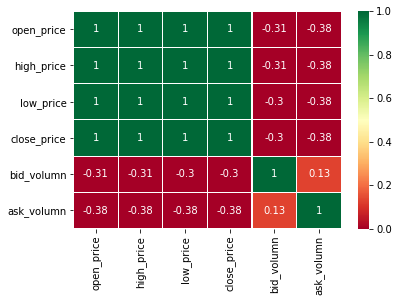

In [2]:
sns.heatmap(dataset.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [3]:

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#test =  series_to_supervised(values, 1, 1)
#print(test.head())
#print(test.shape)


In [4]:
print(values.shape)
print(reframed.shape)
#print(reframed.columes)

(1758, 6)
(1757, 12)


In [5]:
import math

# drop columns we don't want to predict
# 只留下 close 列
reframed.drop(reframed.columns[[6, 7, 8, 10, 11]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
print(values.shape)

n_train_rate = 0.7
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
print(n_train)

train = values[:n_train, :]
test = values[n_train:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var4(t)
1   0.510866   0.503782   0.520185   0.511098   0.053977   0.172456  0.512790
2   0.511098   0.505318   0.520210   0.512790   0.038169   0.108581  0.512177
3   0.512790   0.505197   0.521365   0.512177   0.088890   0.265539  0.512732
4   0.512177   0.506088   0.521520   0.512732   0.042646   0.109454  0.511863
5   0.512732   0.505140   0.521200   0.511863   0.067706   0.418379  0.512208
(1757, 7)
1229
(1229, 1, 6) (1229,) (528, 1, 6) (528,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1229 samples, validate on 528 samples
Epoch 1/50
 - 1s - loss: 0.5470 - val_loss: 0.5896
Epoch 2/50
 - 0s - loss: 0.3387 - val_loss: 0.3287
Epoch 3/50
 - 0s - loss: 0.0937 - val_loss: 0.0201
Epoch 4/50
 - 0s - loss: 0.0792 - val_loss: 0.0515
Epoch 5/50
 - 0s - loss: 0.0500 - val_loss: 0.1071
Epoch 6/50
 - 0s - loss: 0.0344 - val_loss: 0.0579
Epoch 7/50
 - 0s - loss: 0.0435 - val_loss: 0.0741
Epoch 8/50
 - 0s - loss: 0.0344 - val_loss: 0.0729
Epoch 9/50
 - 0s - loss: 0.0307 - val_loss: 0.0621
Epoch 10/50
 - 0s - loss: 0.0278 - val_loss: 0.0494
Epoch 11/50
 - 0s - loss: 0.0277 - val_loss: 0.0430
Epoch 12/50
 - 0s - loss: 0.0244 - val_loss: 0.0321
Epoch 13/50
 - 0s - loss: 0.0238 - val_loss: 0.0255
Epoch 14/50
 - 0s - loss: 0.0205 - val_loss: 0.0135
Epoch 15/50
 - 0s - loss: 0.0206 - val_loss: 0.0101
Epoch 16/50
 - 0s - loss: 0.0157 - val_loss: 0.0115
Epoch 17/5

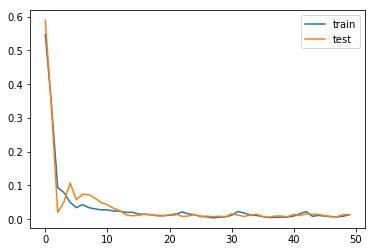

In [6]:
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
print('yhat.shape', yhat.shape, yhat[0:5, :])
test_X_reshape = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X_reshape.shape, test_X_reshape[0:5, -7:])
      
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshape[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
print('inv_yhat.shape', inv_yhat.shape, inv_yhat[0:5, :])

inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_reshape[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
# 因为inv_y 预测是下一时刻的值，所以需要把 inv_yhat 往后 shift 一个时刻
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

yhat.shape (528, 1) [[0.73279685]
 [0.7307423 ]
 [0.7282253 ]
 [0.73145664]
 [0.7276911 ]]
(528, 6) [[0.72062504 0.70995986 0.7317053  0.7191711  0.06822511 0.13928361]
 [0.71917474 0.708531   0.7322225  0.7191796  0.07361542 0.08982905]
 [0.7191796  0.71001214 0.73122615 0.7181757  0.03891451 0.07052667]
 [0.7181757  0.70754206 0.7285442  0.7175435  0.08720351 0.14378987]
 [0.7175435  0.70691913 0.7218804  0.7102124  0.04060328 0.2051018 ]]
inv_yhat.shape (528, 6) [[6.0734200e+05 5.9725800e+05 5.9557300e+05 5.9604900e+05 1.1936801e+03
  9.0791602e+02]
 [6.0563919e+05 5.9605600e+05 5.9599400e+05 5.9605600e+05 1.2879900e+03
  5.8554797e+02]
 [6.0355312e+05 5.9730200e+05 5.9518300e+05 5.9522400e+05 6.8085602e+02
  4.5972601e+02]
 [6.0623125e+05 5.9522400e+05 5.9300000e+05 5.9470000e+05 1.5257300e+03
  9.3728998e+02]
 [6.0311038e+05 5.9470000e+05 5.8757600e+05 5.8862400e+05 7.1040302e+02
  1.3369500e+03]]
Test RMSE: 10626.626


(528, 1, 6)


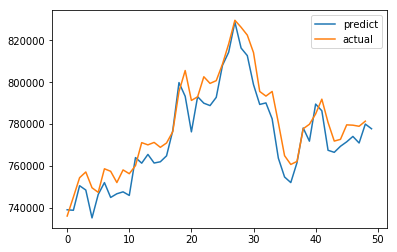

0.6875


In [8]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y[-50:], label='predict')
pyplot.plot( inv_yhat[-49:], label='actual')
pyplot.legend()
pyplot.show()

#涨跌的判准率

#获取预测跟实际对应元素值，是否大于0
a = np.diff(inv_y[-50:-1]) > 0
b = np.diff(inv_yhat[-49:]) > 0

#比较相同值的个数
print(sum(a ==b)/a.shape[0])

## Multivariat with Multiple Lag Timesteps

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('update_20190301_bitbank_f.csv', header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
# 等于 dataset.shape[1]
# for alpha's bitbank, n_features = 6
n_features = 5


# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

print(dataset.shape)
print(reframed.shape)


(1758, 6)
(1755, 24)


(1228, 15) 1228 (1228,)
(1228, 3, 5) (1228,) (527, 3, 5) (527,)
Train on 1228 samples, validate on 527 samples
Epoch 1/50
 - 1s - loss: 0.4590 - val_loss: 0.3132
Epoch 2/50
 - 0s - loss: 0.0520 - val_loss: 0.0375
Epoch 3/50
 - 0s - loss: 0.0527 - val_loss: 0.0553
Epoch 4/50
 - 0s - loss: 0.0588 - val_loss: 0.0721
Epoch 5/50
 - 0s - loss: 0.0462 - val_loss: 0.0710
Epoch 6/50
 - 0s - loss: 0.0432 - val_loss: 0.0595
Epoch 7/50
 - 0s - loss: 0.0406 - val_loss: 0.0528
Epoch 8/50
 - 0s - loss: 0.0371 - val_loss: 0.0401
Epoch 9/50
 - 0s - loss: 0.0353 - val_loss: 0.0320
Epoch 10/50
 - 0s - loss: 0.0320 - val_loss: 0.0198
Epoch 11/50
 - 0s - loss: 0.0298 - val_loss: 0.0111
Epoch 12/50
 - 0s - loss: 0.0277 - val_loss: 0.0153
Epoch 13/50
 - 0s - loss: 0.0251 - val_loss: 0.0176
Epoch 14/50
 - 0s - loss: 0.0097 - val_loss: 0.0148
Epoch 15/50
 - 0s - loss: 0.0099 - val_loss: 0.0108
Epoch 16/50
 - 0s - loss: 0.0080 - val_loss: 0.0119
Epoch 17/50
 - 0s - loss: 0.0095 - val_loss: 0.0131
Epoch 18/50
 -

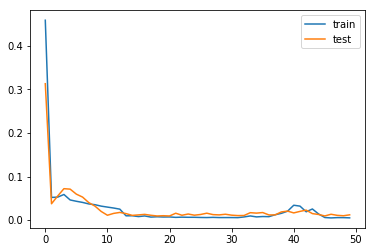

Test RMSE: 41687.780


In [23]:

# split into train and test sets
values = reframed.values
n_train_rate = 0.7
n_train = values.shape[0] * n_train_rate
n_train = math.floor(n_train)
train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
# 7 -> test_X.shape[1] - 1
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [24]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 29154.725


(527, 15)


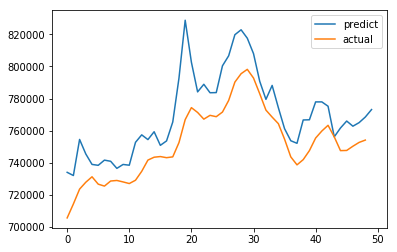

In [25]:
print(test_X.shape)
#print(range(test_X.shape))


pyplot.plot( inv_y[-50:], label='predict')
pyplot.plot( inv_yhat[-49:], label='actual')
pyplot.legend()
pyplot.show()

In [26]:
import numpy as np
np.diff(inv_y[-50:-1])
np.diff(inv_yhat[-49:])

array([  8695.8125,   9270.8125,   4286.0625,   3395.8125,  -4597.625 ,
        -1211.375 ,   3169.    ,    348.3125,   -915.75  ,  -1007.    ,
         2057.    ,   5548.9375,   7021.9375,   1791.    ,    411.    ,
         -705.    ,    508.625 ,   8920.0625,  14301.75  ,   7478.5625,
        -3008.9375,  -4167.1875,   2369.25  ,   -841.0625,   2884.9375,
         7261.1875,  11429.5   ,   5230.1875,   2711.25  ,  -5411.5   ,
        -9789.3125, -10209.5625,  -4365.3125,  -4087.625 ,  -9677.8125,
       -11037.5625,  -4970.625 ,   3248.5625,   5630.1875,   7837.4375,
         4387.25  ,   3551.125 ,  -7204.875 ,  -8571.6875,    104.875 ,
         2628.5625,   2383.625 ,   1454.6875], dtype=float32)

In [27]:
#涨跌的判准率

#获取预测跟实际对应元素值，是否大于0
a = np.diff(inv_y[-50:-1]) > 0
b = np.diff(inv_yhat[-49:]) > 0

#比较相同值的个数
print(sum(a ==b)/a.shape[0])

0.6041666666666666
